In [6]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

In [9]:
import os,sys
project_path = os.path.abspath('..')
src_path = os.path.abspath(os.path.join('..','src'))
utils_path = os.path.join(src_path,'utils')

if project_path not in sys.path:
    sys.path.append(project_path)

if utils_path not in sys.path:
    sys.path.append(utils_path)

if src_path not in sys.path:
    sys.path.append(src_path)

import loading_data, ResultsHandler, DataHandler
from loading_data import split_cfid
from visualize_utils import analyzing
from visualize_utils.analyzing import FeatureImportance,extract_distance_name

In [10]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -------------------------------------------------------------------
# Summarize feature importance by groups (chemistry, distances, etc.)
# -------------------------------------------------------------------
def get_sum_fi_df(fi_df):
    """
    Aggregate feature importance values into groups 
    (chemistry, cell-size, distributions, etc.).
    """
    meta_columns = [
        "chem_part", "dist_part", "en_chem", "distance", 
        "database", "model", "target_column", "feature_set"
    ]

    # Feature categories
    feature_types = {t: {f"is_{t}": True} for t in ["chem", "chrg", "cell", "rdf", "adf1", "adf2", "ddf", "nn"]}
    feature_types.update({f"{d}_sum": {"distance": d} for d in ["hellinger", "tvd", "emd"]})

    sums = {}
    for key, params in feature_types.items():
        if "distance" in params:
            sums[key] = pd.DataFrame(split_cfid(fi_df, **params))
        else:
            sums[key] = pd.DataFrame(split_cfid(fi_df, **params).sum(axis=1), columns=[key])

    # Merge results into a single DataFrame
    sum_fi_df = pd.DataFrame(index=sums["cell"].index)
    for key, df in sums.items():
        sum_fi_df = sum_fi_df.merge(df, left_index=True, right_index=True)

    return fi_df[meta_columns].merge(sum_fi_df, left_index=True, right_index=True)


# -------------------------------------------------------------------
# Select models for FI analysis
# -------------------------------------------------------------------
def select_models_for_fi(sum_fi_df, target, selected_dict):
    """
    Filter models by target and selection dictionary.
    """
    filt_target_df = sum_fi_df[sum_fi_df["target_column"] == target]
    selected_model = pd.concat(
        [ResultsHandler.select_methods(filt_target_df, **params) for _, params in selected_dict.items()],
        ignore_index=True,
    )
    return selected_model


# -------------------------------------------------------------------
# Utility: remove 'jml_' prefix from feature names
# -------------------------------------------------------------------
def remove_jml(feature_col: pd.Series):
    return [f.removeprefix("jml_") for f in feature_col]


# -------------------------------------------------------------------
# Plot feature importance (pie chart + top-N bar chart)
# -------------------------------------------------------------------
def plot_fi(fi_df, select_model, target, altered_pct=True):
    """
    Plot feature importance summary:
    - Pie chart for grouped feature categories.
    - Bar chart for top-N individual features.
    """
    # Color map for categories
    color_labels = {
        "chemical": "#aec7e8", "radial charge": "#ffbb78", "cell-size": "#98df8a",
        "ADF1": "#ff9896", "ADF2": "#c5b0d5", "RDF": "#c49c94", "NN": "#f7b6d2",
        "DDF": "#c7c7c7", "distance": "#dbdb8d", "Others": "#9edae5"
    }

    # Naming map for categories
    feature_name_mapping = {
        "chem": "chemical", "chrg": "radial charge", "cell": "cell-size",
        "rdf": "RDF", "adf1": "ADF1", "adf2": "ADF2", "ddf": "DDF", "nn": "NN"
    }
    distance_names = ["tvd", "emd", "hellinger"]
    dist_features = ["rdf", "adf1", "adf2", "ddf", "nn"]
    feature_name_mapping.update({
        f"{f}_{d}": f"{f.upper()}-{d.capitalize() if d == 'hellinger' else d.upper()}"
        for f, d in itertools.product(dist_features, distance_names)
    })

    feature_sets = select_model["feature_set"]
    num_feature_sets = len(feature_sets)

    # Setup subplots
    fig, axs = plt.subplots(nrows=2, ncols=num_feature_sets, figsize=(6 * num_feature_sets, 8))
    if num_feature_sets == 1:  # ensure axs is always 2D array
        axs = np.array([axs]).T

    for i, feature_set in enumerate(feature_sets):
        # Filter by target and feature set
        target_df = fi_df[fi_df["target_column"] == target]
        full_fi_df = target_df[target_df["feature_set"] == feature_set].reset_index(drop=True)

        # Summed feature importance
        sum_fi_series = select_model[select_model["feature_set"] == feature_set].iloc[0, 8:]
        sum_fi_series = sum_fi_series.loc[sum_fi_series != 0]

        # Handle distance feature grouping
        sorted_sum_fi = sum_fi_series.sort_values(ascending=False)
        distance = extract_distance_name(feature_set)
        if distance is not None:
            distance_df = loading_data.split_cfid(pd.DataFrame(sorted_sum_fi).T, distance=distance)
            sum_distance = distance_df.sum(axis=1).rename("distance")
            sorted_sum_fi = sorted_sum_fi.drop(distance_df.columns, errors="ignore")
            sorted_sum_fi = pd.concat([sorted_sum_fi, sum_distance])

        # Keep top 5 groups + "Others"
        if len(sorted_sum_fi) > 6:
            top_fi = sorted_sum_fi[:5].copy()
            top_fi["Others"] = sorted_sum_fi[5:].sum()
        else:
            top_fi = sorted_sum_fi

        # -----------------------------
        # Bar chart: Top-15 individual features
        # -----------------------------
        N_fi_df = (
            full_fi_df.iloc[:, 9:]
            .T.reset_index()
            .rename(columns={"index": "features", 0: "importance"})
            .sort_values("importance", ascending=False)
            .head(15)
            .sort_values("importance")
        )

        removed_labels = remove_jml(N_fi_df["features"])
        axs[1, i].barh(removed_labels, N_fi_df["importance"], color="skyblue", edgecolor="black")
        axs[1, i].set_xlabel("Importance", fontsize=14)
        axs[1, i].tick_params(axis="y", labelsize=12)

        # -----------------------------
        # Pie chart: Grouped categories
        # -----------------------------
        labels = [feature_name_mapping.get(x, x) for x in top_fi.index]
        values = top_fi.values
        total = values.sum()
        wedges, _ = axs[0, i].pie(
            x=values,
            colors=[color_labels.get(k, "#cccccc") for k in labels],
            startangle=90,
            wedgeprops={"edgecolor": "k"},
        )
        axs[0, i].set_title(ResultsHandler.split_feature_set_name(feature_set), fontsize=14)

        # Percentage labels
        angles = np.cumsum([90] + [(v / total) * 360 for v in values])
        for j, (wedge, angle_start, angle_end) in enumerate(zip(wedges, angles[:-1], angles[1:])):
            angle = (angle_start + angle_end) / 2
            dist = 0.6 + j * 0.1 if altered_pct else 0.8
            x, y = dist * np.cos(np.deg2rad(angle)), dist * np.sin(np.deg2rad(angle))
            axs[0, i].text(x, y, f"{100 * values[j] / total:.1f}%", ha="center", va="center", fontsize=12)

    # Legend (shared across subplots)
    legend_elements = [Patch(facecolor=color, edgecolor="black", label=label) for label, color in color_labels.items()]
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0, -0.11, 1, 0.1),
        mode="expand",
        fontsize=12,
        title="Feature Categories",
        title_fontsize=14,
        ncols=10,
        frameon=False,
    )

    plt.tight_layout()
    return fig


In [11]:
def main(target,optimize,selected_dict,**kwargs):
    config = loading_data.load_config_file('../configs/r4_config_allv2.yaml')
    fi_obj = FeatureImportance()
    fi_df = fi_obj.get_feature_importances(config,optimize=optimize,N=None,result_dirname='results_2')
    fi_df = ResultsHandler.transform_feature_set_column(fi_df,include_feature_name=True)
    fi_df = DataHandler.rename_cell_columns(fi_df)

    sum_fi_df = get_sum_fi_df(fi_df)

    selected_model = select_models_for_fi(sum_fi_df,target,selected_dict)
    fig = plot_fi(fi_df, selected_model, target=target,**kwargs)
    return fig

========================================= formation energy per site =========================================
===> include distribution features


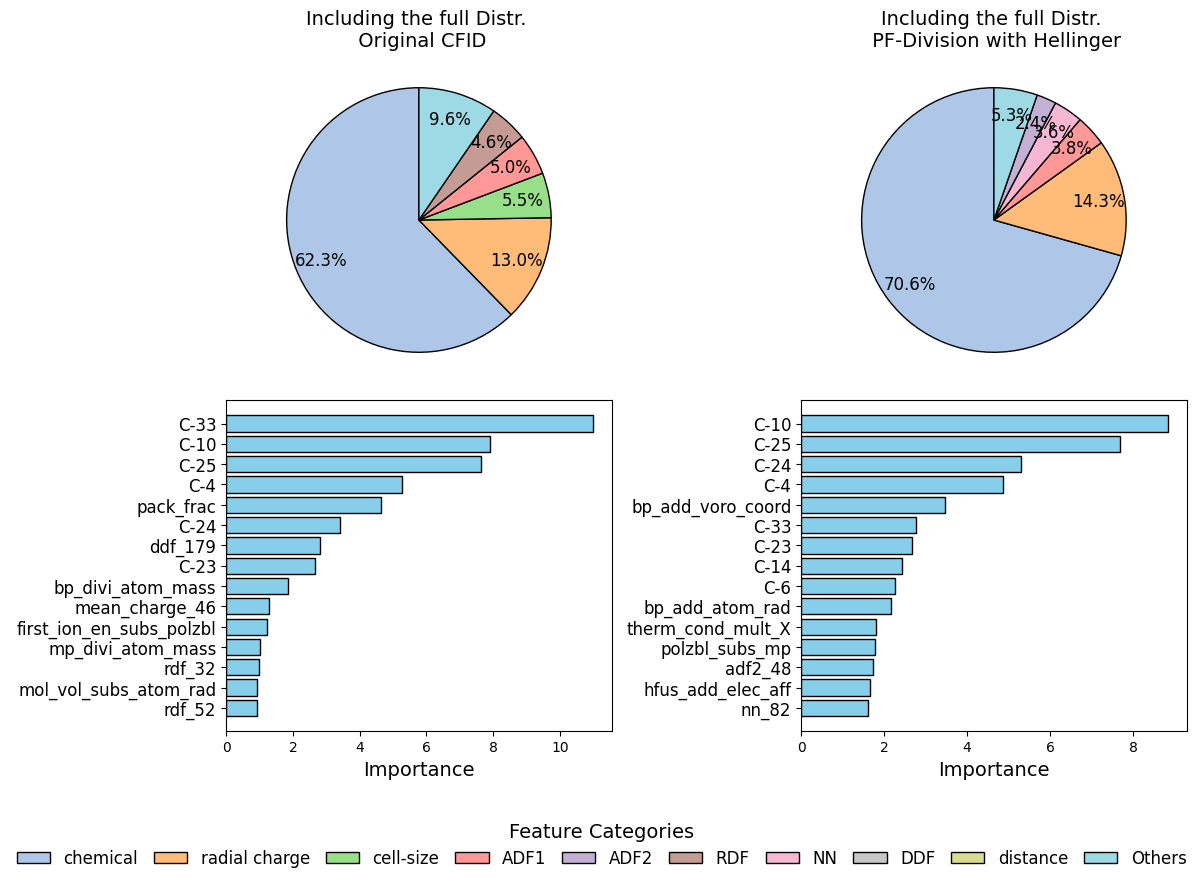

===> exclude distribution features


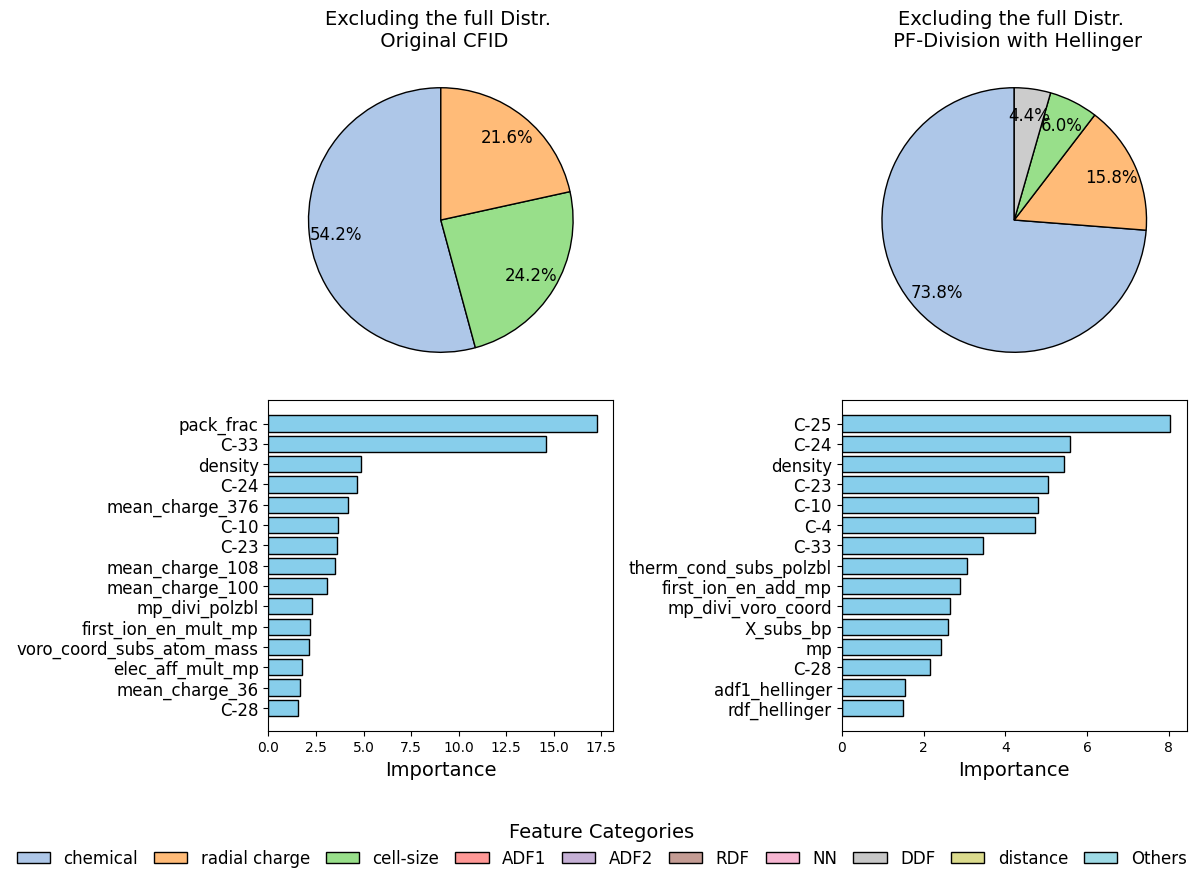

========================================= homo lumo gap min =========================================
===> include distribution features


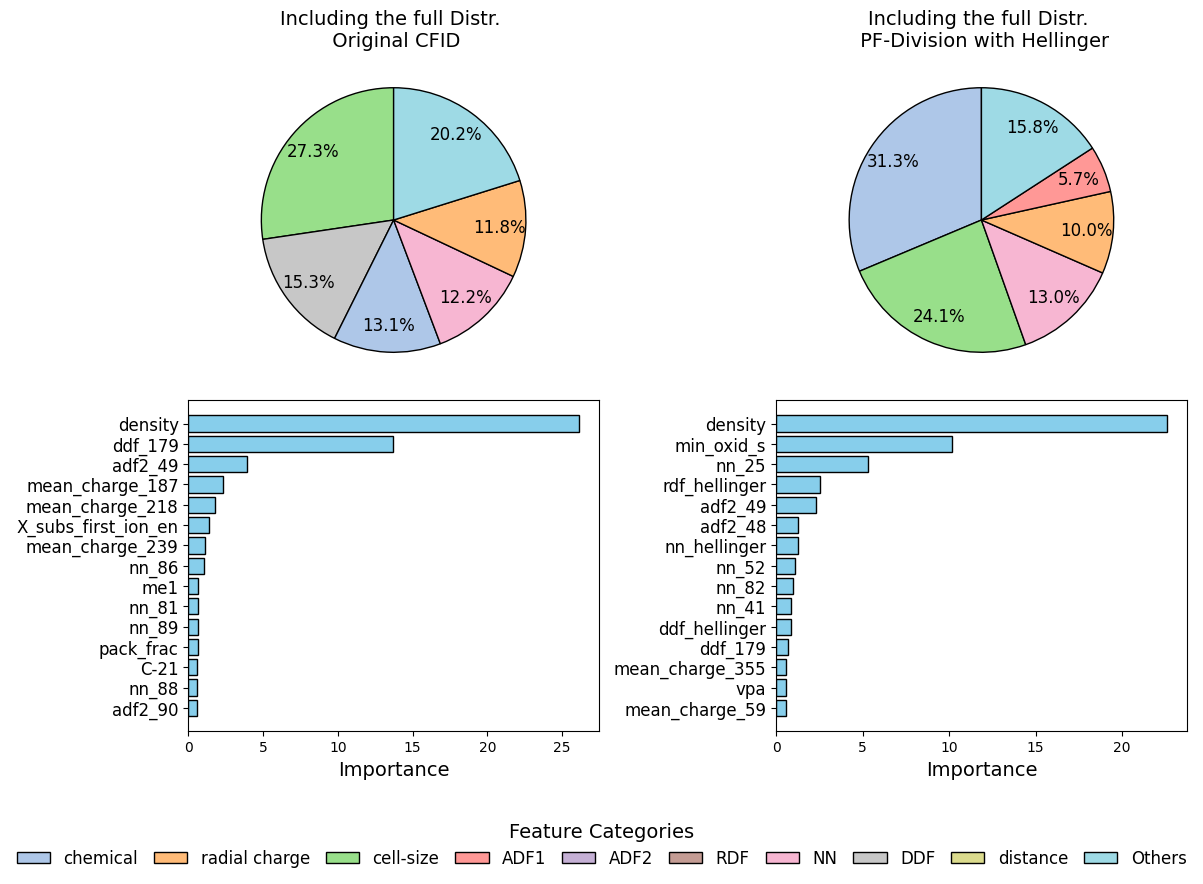

===> exclude distribution features


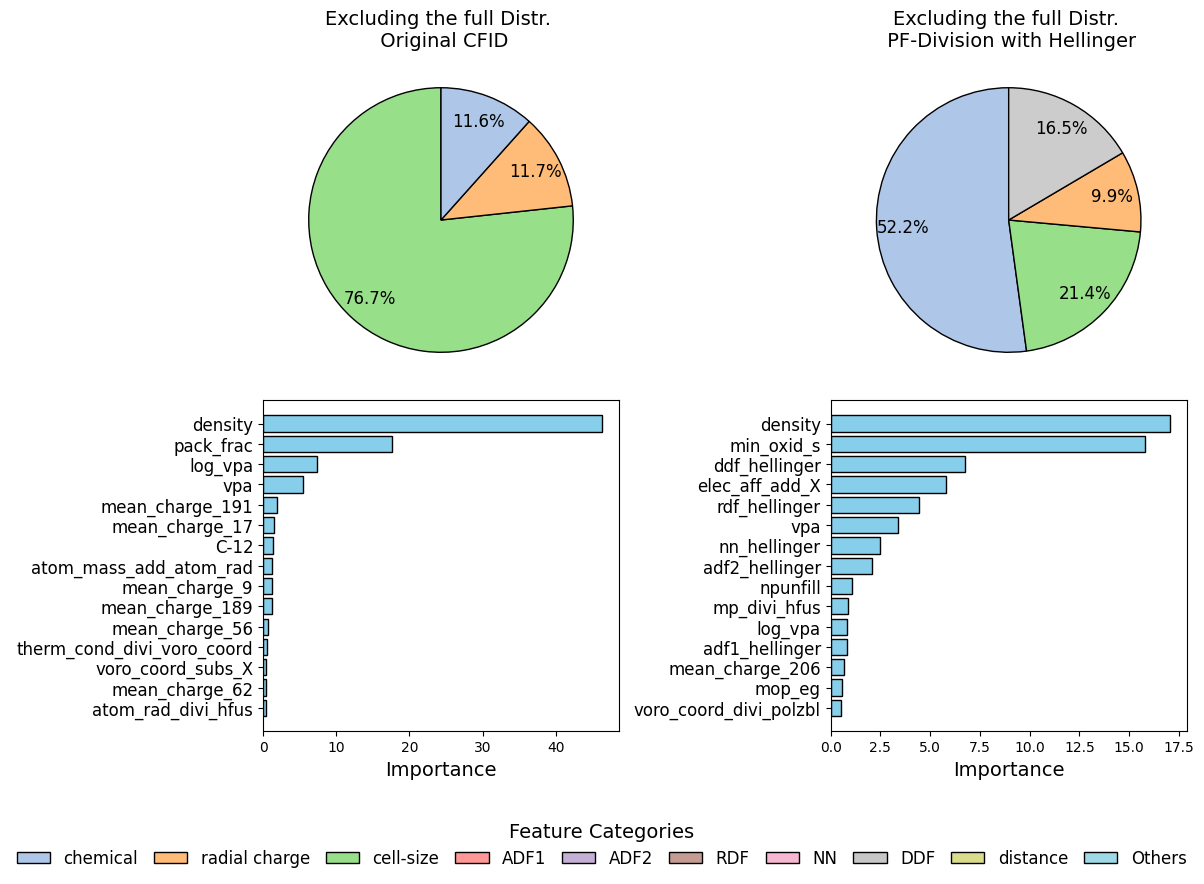

In [12]:
# target = 'formation_energy_per_site'
selected_dict_incl = {
                'model0':{'dist_part':'alldist', 'en_chem':'no',       'distance':'no'},
                'model1':{'dist_part':'alldist', 'en_chem':'vpa_divi', 'distance':'hellinger'},
                # 'model2':{'dist_part':'no', 'en_chem':'no', 'distance':'no'},
                # 'model3':{'dist_part':'no', 'en_chem':'vpa_divi', 'distance':'hellinger'},
                }

selected_dict_excl = {
                'model0':{'dist_part':'no', 'en_chem':'no',       'distance':'no'},
                'model1':{'dist_part':'no', 'en_chem':'vpa_divi', 'distance':'hellinger'},
                # 'model2':{'dist_part':'no', 'en_chem':'no', 'distance':'no'},
                # 'model3':{'dist_part':'no', 'en_chem':'vpa_divi', 'distance':'hellinger'},
                }

print("========================================= formation energy per site =========================================")
print("===> include distribution features")
main_incl_fig_eform = main(target='formation_energy_per_site',optimize= 'selected_best_random_100',selected_dict=selected_dict_incl,altered_pct=False)
plt.show()
# main_incl_fig_eform.savefig('saved_figures/fi_incl_eform.pdf',bbox_inches='tight')

print("===> exclude distribution features")
main_excl_fig_eform = main(target='formation_energy_per_site',optimize= 'selected_best_random_100',selected_dict=selected_dict_excl,altered_pct=False)
plt.show()
# main_excl_fig_eform.savefig('saved_figures/fi_excl_eform.pdf',bbox_inches='tight')


print("========================================= homo lumo gap min =========================================")

print("===> include distribution features")
main_fig_gap = main(target='homo_lumo_gap_min',optimize= 'selected_best_random_100',selected_dict=selected_dict_incl,altered_pct=False)
plt.show()
# main_fig_gap.savefig('saved_figures/fi_incl_gap.pdf',bbox_inches='tight')

print("===> exclude distribution features")
main_fig_gap = main(target='homo_lumo_gap_min',optimize= 'selected_best_random_100',selected_dict=selected_dict_excl,altered_pct=False)
plt.show()
# main_fig_gap.savefig('saved_figures/fi_excl_gap.pdf',bbox_inches='tight')
# fig_excl = main(target=target,optimize= 'selected_best_random_100',selected_dict=selected_dict_excl,altered_pct=False)
# fig_incl.savefig(f"saved_figures/fi_gap_incl_main.pdf",bbox_inches='tight',dpi=300)
# fig_excl.savefig(f"saved_figures/fi_gap_excl_main.pdf",bbox_inches='tight',dpi=300)
